<a href="https://colab.research.google.com/github/Nik8x/Anti_money_Laundering/blob/master/Financial_Transactions_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://web.archive.org/web/20161019192412im_/http://lisp.vse.cz/pkdd99/data.gif)

[Guide to the Financial Data Set](https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm)
    
[1999 Czech Financial Dataset - Real Anonymized Transactions](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions)

In [1]:
# Importing necessary libraries

# pandas for data manipulation and show all rows and columns
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# numpy for numerical computations
import numpy as np

# glob for file operations
import glob

# time for time-related operations
import time

# regex for regular expression operations
import regex as re

# warnings for handling warnings
import warnings
warnings.filterwarnings('ignore')  # ignoring warnings

# statsmodels for statistical models
import statsmodels.api as sm

# scipy.stats for statistical functions
import scipy.stats as scs

# variance_inflation_factor for checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn for statistical data visualization
import seaborn as sns

# scatter_matrix for creating a scatter matrix
from pandas.plotting import scatter_matrix

# sklearn for machine learning algorithms and related operations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  #GBM algorithm

# xgboost for XGBoost algorithm
from xgboost import XGBClassifier

# statsmodels for statistical models
import statsmodels.api as sm

In [2]:
# Use the glob module to find all CSV files in the current directory
files = sorted(glob.glob('*.csv'))  # The sorted() function sorts the list in ascending order
print(files)

['account.csv', 'card.csv', 'client.csv', 'disp.csv', 'district.csv', 'loan.csv', 'order.csv']


In [3]:
import csv

In [106]:
print("The dataframes created from csv's are:\n")

# Loop over each filename in the files list
for f in files:
    # Create a DataFrame from the CSV file
    # Use the filename (minus the '.csv' extension) as the variable name
    vars()[f.split('.')[0]] = pd.read_csv(f, delimiter = ';')#.replace(r'\s+', np.nan, regex = True)

    # Print the shape of the DataFrame
    print("Shape of **", f.split('.')[0], "** dataframe is: ", vars()[f.split('.')[0]].shape)

trans = pd.read_csv('trans.csv', delimiter = ',')
print("Shape of **", "trans", "** dataframe is: ", trans.shape)

The dataframes created from csv's are:

Shape of ** account ** dataframe is:  (4500, 4)
Shape of ** card ** dataframe is:  (892, 4)
Shape of ** client ** dataframe is:  (5369, 3)
Shape of ** disp ** dataframe is:  (5369, 4)
Shape of ** district ** dataframe is:  (77, 16)
Shape of ** loan ** dataframe is:  (682, 7)
Shape of ** order ** dataframe is:  (6471, 6)
Shape of ** trans ** dataframe is:  (1056320, 11)


### Account
*   account_id: identification of the account
*   district_id: location of the branch
*   date: date of creating of the account	in the form YYMMDD
*   frequency:	frequency of issuance of statements	"POPLATEK MESICNE" stands for monthly issuance, "POPLATEK TYDNE" stands for weekly issuance, "POPLATEK PO OBRATU" stands for issuance after transaction

In [5]:
# convert account date into datetime formatfrom yymmdd format
account['date'] = pd.to_datetime(account['date'], format = '%y%m%d')

# change codes to text
account['frequency'] = account['frequency'].replace({
    "POPLATEK MESICNE": "monthly issuance",
    "POPLATEK TYDNE": "weekly issuance",
    "POPLATEK PO OBRATU": "issuance after transaction"
})

print(account.shape)
account[:4]

(4500, 4)


,account_id,district_id,frequency,date
0,576,55,monthly issuance,1993-01-01
1,3818,74,monthly issuance,1993-01-01
2,704,55,monthly issuance,1993-01-01
3,2378,16,monthly issuance,1993-01-01


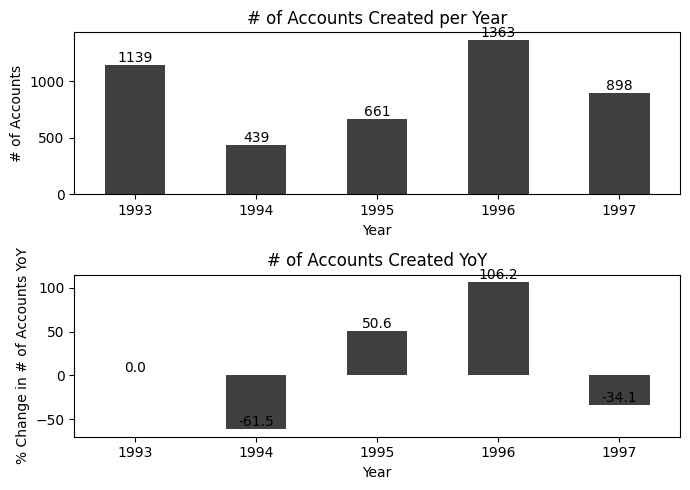

In [6]:
fig, axes = plt.subplots(2, 1, figsize = (7, 5))

# # of Accounts Created per Year
account_year_count = account.date.dt.year.value_counts().sort_index()
ax = account_year_count.plot(kind = 'bar', ax = axes[0], color = 'k', alpha = 0.75, rot = 0)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('# of Accounts')
axes[0].set_title('# of Accounts Created per Year')

# number of accounts created yoy
account_yoy_change = (account.date.dt.year.value_counts().sort_index().pct_change() * 100).round(1)
ax = account_yoy_change.plot(kind = 'bar', ax = axes[1], color = 'k', alpha = 0.75, rot = 0)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('% Change in # of Accounts YoY')
axes[1].set_title('# of Accounts Created YoY')

plt.tight_layout()
plt.show()

The Year-over-Year (YoY) data indicates fluctuations in the number of accounts created annually suggesting potential trends in customer acquisition and retention.

*   significant decline in 1994
*   significant increase in new accounts in 1996
*   slight decline in 1997

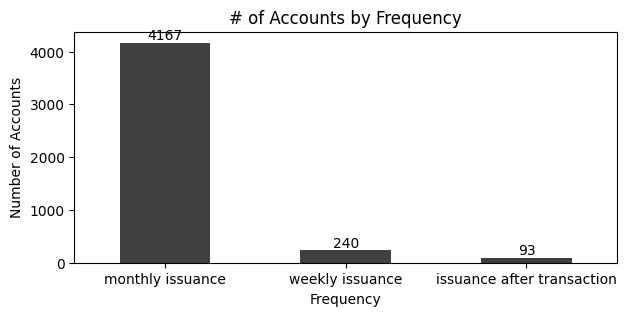

In [7]:
# Frequency distribution by # of accounts
ax = account['frequency'].value_counts().plot(kind = 'bar', figsize = (7, 3),
                                    title = '# of Accounts by Frequency', color = 'k', alpha = 0.75, rot = 0)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')

ax.set_xlabel('Frequency')
ax.set_ylabel('Number of Accounts')
plt.show()

Most of the statements are generated at a regular cadence of monthly followed by weekly, while statement issuance after transation happens rarely

### Client
*   client_id:	client identifier
*   birth number:	birthday and sex,	the number is in the form YYMMDD for men, the number is in the form YYMM+50DD for women, where YYMMDD is the date of birth
*   district_id:	address of the client

In [8]:
# creating a birthday and gender column using birth number
client['gender'] = client.birth_number.apply(lambda x: 'M' if int(str(x)[2:4]) <= 12 else 'F')
client['birth_month'] = client.birth_number.apply(lambda x: (str(x)[2:4]) if int(str(x)[2:4]) <= 12 else str(int(str(x)[2:4]) - 50).zfill(2))
# replace the month in  birth_number with birth_month column value
client['birth_number'] = client.birth_number.apply(lambda x: str(x)[0:2] + str(client[client['birth_number'] == x]['birth_month'].values[0]) + str(x)[4:])
# convert birth_number into datetime format & in some cases, datetime is parsing wrong year, below code to correct that
client['birth_number'] = pd.to_datetime(client['birth_number'], format = '%y%m%d', errors = 'coerce')
client.loc[client['birth_number'].dt.year > 2000, 'birth_number'] = client.loc[client['birth_number'].dt.year > 2000, 'birth_number'].apply(lambda x: x.replace(year = x.year - 100))
client = client.drop('birth_month', axis = 1) # dropping month

print(client.shape)
client[:4]

(5369, 4)


,client_id,birth_number,district_id,gender
0,1,1970-12-13,18,F
1,2,1945-02-04,1,M
2,3,1940-10-09,1,F
3,4,1956-12-01,5,M


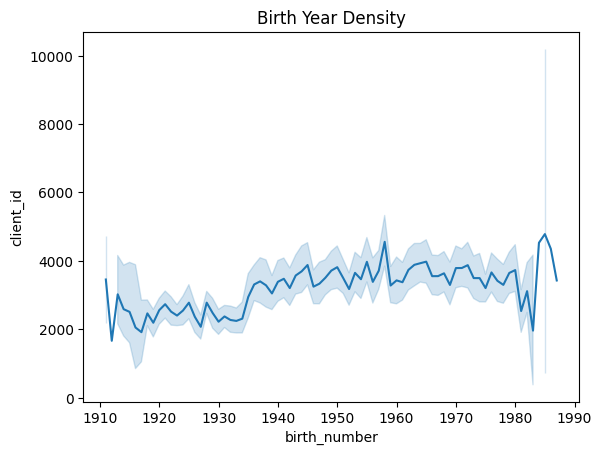

In [22]:
# birth year density
fig, ax = plt.subplots()
sns.lineplot(x = client['birth_number'].dt.year, y = 'client_id', data = client, ax = ax)
ax.set_title('Birth Year Density')
plt.show()

The distribution of account holders with the highest counts clustered around the mid-20th century, suggesting a peak in account holders born during this period. Additionally, there's a notable decrease in counts for account holders born in the early 20th century, indicating a decline in representation from older age groups.

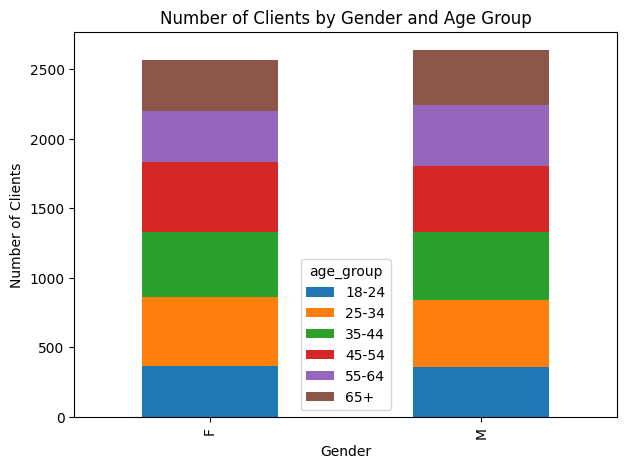

In [23]:
# plot number of clients by gender and age

# Create a new column 'age' by subtracting the birth year from the year 1998 (1997+1) as that is the year we have accounts table max year
client['age_in_1998'] = 1998 - client['birth_number'].dt.year
# Create a new column 'age_group' by binning the age into groups
client['age_group'] = pd.cut(client['age_in_1998'], bins = [18, 25, 35, 45, 55, 65, np.inf], labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
# Create a crosstab of gender and age group
gender_age_crosstab = pd.crosstab(client['gender'], client['age_group'])

gender_age_crosstab.plot(kind = 'bar', stacked = True, figsize = (7, 5))
plt.title('Number of Clients by Gender and Age Group')
plt.xlabel('Gender')
plt.ylabel('Number of Clients')
plt.show()

In [11]:
print(gender_age_crosstab) # crosstab

age_group  18-24  25-34  35-44  45-54  55-64  65+
gender                                           
F            365    496    466    502    368  369
M            356    481    491    476    439  394


 A relatively balanced distribution of account holders across age groups for both genders.

*   slight predominance of females in the 25-34 & 45-54 age group
*   males show slightly higher counts in the 35-44 & 55-64 age groups

In [12]:
client = client.drop(['age_in_1998', 'age_group'], axis = 1) # dropping columns

### Disposition
*   disp_id:	record identifier
*   client_id:	identification of a client
*   account_id:	identification of an account
*   type:	type of disposition (owner/user), only owner can issue permanent orders and ask for a loan

In [26]:
print(disp.shape)
disp.head()

(5369, 4)


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [18]:
disp.disp_id.nunique(), disp.client_id.nunique(), disp.account_id.nunique()

(5369, 5369, 4500)

Looks like we have data for all the clients, and all the accounts as the numbers match previous numbers

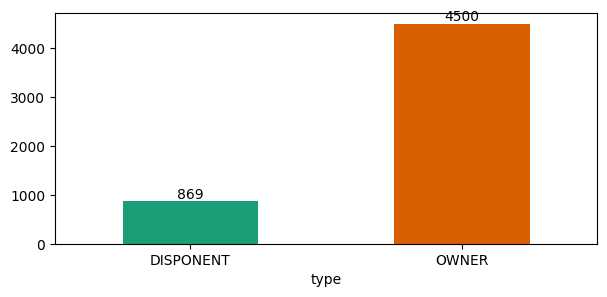

In [25]:
ax = disp.groupby('type').size().plot(kind = 'bar', figsize = (7, 3), color = sns.palettes.mpl_palette('Dark2'), rot = 0)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')
plt.show()

In [42]:
# number of account_id with two or more than two type
disp.groupby('account_id')['type'].nunique().gt(1).sum()

869

869 accounts or around 1 in 5 accounts have at least one secondary user, it can be interesting to see if they have any odd behavior

### Order
*   order_id:	record identifier
*   account_id:	account, the order is issued for
*   bank_to:	bank of the recipient,	each bank has unique two-letter code
*   account_to:	account of the recipient
*   amount:	debited amount
*   K_symbol:	characterization of the payment	"POJISTNE" stands for insurrance payment: "SIPO" stands for household payment, "LEASING" stands for leasing, "UVER" stands for loan payment







In [96]:
# change codes to text
order['k_symbol'] = order['k_symbol'].replace({
    "POJISTNE": "insurance payment",
    "SIPO": "household payment",
    "LEASING": "leasing",
    "UVER" : "loan payment"
})

order['k_symbol'] = order['k_symbol'].apply(lambda x: np.nan if re.match(r'\s+', x) else x) # replace empty strings with nan
print(order.shape)
order.head()

(6471, 6)


,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,household payment
1,29402,2,ST,89597016,3372.7,loan payment
2,29403,2,QR,13943797,7266.0,household payment
3,29404,3,WX,83084338,1135.0,household payment
4,29405,3,CD,24485939,327.0,NaN


In [97]:
order.order_id.nunique(), order.account_id.nunique(), order.bank_to.nunique(), order.account_to.nunique(), order.k_symbol.nunique()

(6471, 3758, 13, 6446, 4)

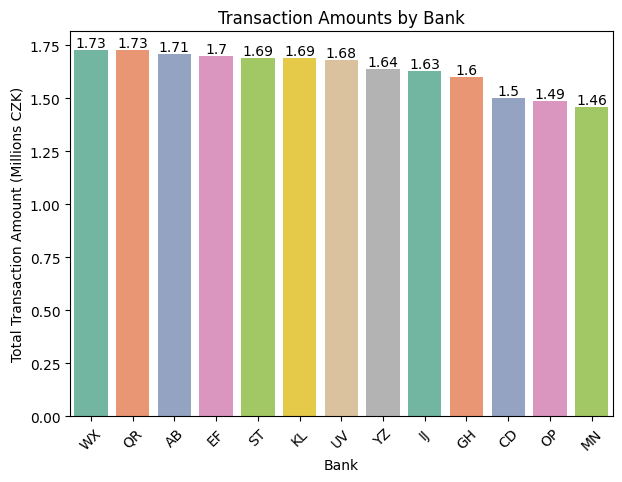

In [98]:
# Transaction Amounts by Bank
grouped_data = order.groupby('bank_to')['amount'].sum().sort_values(ascending = False)

plt.figure(figsize = (7, 5))
ax = sns.barplot(x =grouped_data.index, y =  np.round(grouped_data.values / 1000000, 2), palette = 'Set2')
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')

plt.xlabel('Bank')
plt.ylabel('Total Transaction Amount (Millions CZK)')
plt.title('Transaction Amounts by Bank')
plt.xticks(rotation = 45)
plt.show()

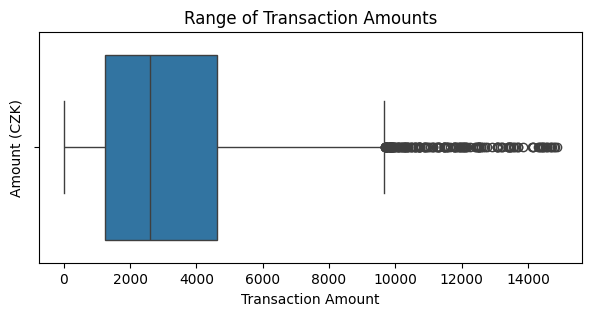

In [99]:
# Box Plot of Transaction Amounts
plt.figure(figsize = (7, 3))
sns.boxplot(x = order['amount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Amount (CZK)')
plt.title('Range of Transaction Amounts')
plt.show()

The box plot shows the presence of outliers. These outliers indicate that there are some transactions with significantly higher amounts compared to the majority of the transactions. Can be due to a variety of reasons, such as: Large purchases or payments, Fraudulent transactions, Data entry errors

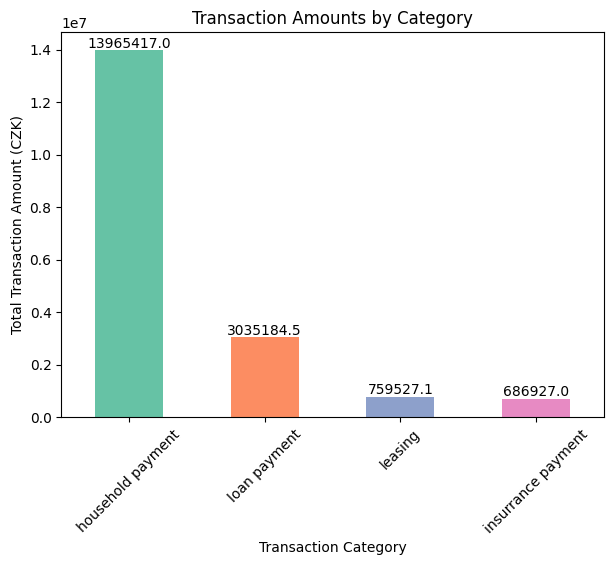

In [93]:
# Transaction Amounts by Category:
k_symbol_grouped = order.groupby('k_symbol')['amount'].sum().sort_values(ascending = False)
colors = sns.color_palette('Set2', len(k_symbol_grouped))

plt.figure(figsize = (7, 5))
ax = k_symbol_grouped.plot(kind = 'bar', stacked = True, color = colors)
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()),
                ha = 'center', va = 'bottom')

plt.xlabel('Transaction Category')
plt.ylabel('Total Transaction Amount (CZK)')
plt.title('Transaction Amounts by Category')
plt.xticks(rotation = 45)
plt.show()

The highest transaction amount is for the "household payment" category of around 14M CZK, followed by the "loan payment" and "leasing" categories. The "insurance payment" category has the lowest transaction amount.

In [47]:
# are the account_to ids present in the account dataframe account_id
account_to_ids = order['account_to'].unique()
account_ids = account['account_id'].unique()

present_in_account = []
not_present_in_account = []

for account_to_id in account_to_ids:
    if account_to_id in account_ids:
        present_in_account.append(account_to_id)
    else:
        not_present_in_account.append(account_to_id)

print(f"Number of account_to IDs present in account dataframe: {len(present_in_account)}")
print(f"Number of account_to IDs not present in account dataframe: {len(not_present_in_account)}")
print(f"Account IDs present: {present_in_account}")

Number of account_to IDs present in account dataframe: 2
Number of account_to IDs not present in account dataframe: 6444
Account IDs present: [1460, 399]


### Transaction
* trans_id:	record identifier
* account_id:	account, the transation deals with
* date:	date of transaction,	in the form YYMMDD
* type:	+/- transaction,	"PRIJEM" stands for credit, "VYDAJ" stands for withdrawal
* operation:	mode of transaction,	"VYBER KARTOU" credit card withdrawal, "VKLAD" credit in cash, "PREVOD Z UCTU" collection from another bank, "VYBER" withdrawal in cash, "PREVOD NA UCET" remittance to another bank
* amount:	amount of money
* balance:	balance after transaction
* k_symbol:	characterization of the transaction,	"POJISTNE" stands for insurrance payment, "SLUZBY" stands for payment for statement, "UROK" stands for interest credited, "SANKC. UROK" sanction interest if negative balance, "SIPO" stands for household, "DUCHOD" stands for old-age pension, "UVER" stands for loan payment
* bank:	bank of the partner	each bank has unique two-letter code
* account:	account of the partner

In [113]:
trans = trans.drop('Unnamed: 0', axis = 1)
# change codes to text
trans['type'] = trans['type'].replace({
    "PRIJEM": "credit",
    "VYDAJ": "withdrawl" })
trans['operation'] = trans['operation'].replace({
    "VYBER KARTOU": "credit card withdrawal",
    "VKLAD": "credit in cash",
    "PREVOD Z UCTU" : "collection from another bank",
    "VYBER" : "withdrawal in cash",
    "PREVOD NA UCET" : "remittance to another bank"
    })
trans['k_symbol'] = trans['k_symbol'].replace({
    "POJISTNE": "insurrance payment",
    "SLUZBY": "payment for statement",
    "UROK" : "interest credited",
    "SANKC. UROK" : "sanction interest if negative balance",
    "SIPO" : "household",
    "DUCHOD" : "old-age pension",
    "UVER" : "loan payment"})
# convert date into datetime formatfrom yymmdd format
trans['date'] = pd.to_datetime(trans['date'], format = '%y%m%d')

In [116]:
print(trans.shape)
trans.head()

(1056320, 10)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,credit,credit in cash,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,credit,credit in cash,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,credit,credit in cash,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,credit,credit in cash,400.0,400.0,NaN,NaN,NaN


In [115]:
trans.isnull().sum() # looking at null values

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64

### Card

In [118]:
card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [15]:
# Rename the columns of the district DataFrame
district.columns = ["district code", "district name", "region", "no. of inhabitants",
                    "no. of municipalities with inhabitants < 499",
                    "no. of municipalities with inhabitants 500-1999",
                    "no. of municipalities with inhabitants 2000-9999",
                    "no. of municipalities with inhabitants >10000",
                    "no. of cities", "ratio of urban inhabitants" , "average salary",
                    "unemploymant rate 95", "unemploymant rate 96",
                    "no. of enterpreneurs per 1000 inhabitants", "no. of commited crimes 95",
                    "no. of commited crimes 96"]

district.head()

,district code,district name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96
0,1,NaN,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,NaN,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,NaN,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,NaN,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,NaN,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [16]:
# Convert the 'district code' column to integer data type
district['district code'] = district['district code'].astype(int)

In [24]:
trans.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation          0
amount             0
balance       183114
k_symbol      535314
bank          782812
account       760931
dtype: int64

In [ ]:
# Merge 'account' and 'loan' dataframes on 'account_id'
df1 = pd.merge(account.rename(columns = {'date' : 'date_account'}), loan.rename(columns = {'date' : 'date_loan'}),
               left_on = 'account_id', right_on = 'account_id', how = 'inner')

# Merge 'account' and 'order' dataframes on 'account_id'
df2 = pd.merge(account['account_id'], order, left_on = 'account_id', right_on = 'account_id', how = 'inner')

# Merge 'account' and 'trans' dataframes on 'account_id'
df3 = pd.merge(account['account_id'], trans, left_on = 'account_id', right_on = 'account_id', how = 'inner')

# Merge 'account' and 'district' dataframes on 'district_id' and 'district code'
df4 = pd.merge(account['district_id'], district, left_on = 'district_id', right_on = 'district code', how = 'inner').drop('district code', axis = 1)

# Merge 'account' and 'disp' dataframes on 'account_id'
df5 = pd.merge(account['account_id'], disp, left_on = 'account_id', right_on = 'account_id', how = 'inner')

# Merge 'disp' and 'card' dataframes on 'disp_id'
df = pd.merge(disp.rename(columns = {'type' : 'type_disp'}), card.rename(columns = {'type' : 'type_card'}),
              left_on = 'disp_id', right_on = 'disp_id', how = 'inner')

# Merge 'disp' and 'client' dataframes on 'client_id'
df = pd.merge(df, client, left_on = 'client_id', right_on = 'client_id', how = 'inner')

# Merge 'account' and the previously merged dataframe on 'account_id'
df6 = pd.merge(account['account_id'], df, left_on = 'account_id', right_on = 'account_id', how = 'inner')

In [ ]:
# join all 8 dataframes

df = df1.merge(df2, on = 'account_id', how = 'inner')
df = df.merge(df3, on = 'account_id', how = 'inner')
df = df.merge(df4, on = 'district_id', how = 'inner')
df = df.merge(df5, on = 'account_id', how = 'inner')
df = df.merge(df6, on = 'account_id', how = 'inner')


In [ ]:
# Merge 'account' and 'loan' dataframes on 'account_id'
df1 = pd.merge(account.rename(columns = {'date' : 'date_account', 'district_id' : 'district_id_branch'}), loan.rename(columns = {'date' : 'date_loan', 'amount' : 'amount_account'}),
               left_on = 'account_id', right_on = 'account_id', how = 'left')

# Merge 'account' and 'order' dataframes on 'account_id'
df2 = pd.merge(df1, order.rename(columns = {'amount' : 'amount_order', 'k_symbol' : 'k_symbol_order'}),
               left_on = 'account_id', right_on = 'account_id', how = 'left')

# Merge 'account' and 'trans' dataframes on 'account_id'
df3 = pd.merge(df2, trans.rename(columns = {'k_symbol' : 'k_symbol_trans', 'type' : 'type_trans'}),
               left_on = 'account_id', right_on = 'account_id', how = 'left')

# Merge 'account' and 'district' dataframes on 'district_id' and 'district code'
df4 = pd.merge(df3, district, left_on = 'district_id_branch', right_on = 'district code', how = 'left').drop('district code', axis = 1)

# Merge 'account' and 'disp' dataframes on 'account_id'
df5 = pd.merge(df4, disp.rename(columns = {'type' : 'type_disp'}),
               left_on = 'account_id', right_on = 'account_id', how = 'left')

# Merge 'disp' and 'card' dataframes on 'disp_id'
df6 = pd.merge(df5, card.rename(columns = {'type' : 'type_card'}),
              left_on = 'disp_id', right_on = 'disp_id', how = 'left')

# Merge 'disp' and 'client' dataframes on 'client_id'
df7 = pd.merge(df6, client.rename(columns = {'district_id' : 'district_id_client'}),
               left_on = 'client_id', right_on = 'client_id', how = 'left')

In [ ]:
print(df7.shape)
df7[:4]

(2243458, 47)


,account_id,district_id_branch,frequency,date_account,loan_id,date_loan,amount_account,duration,payments,status,order_id,bank_to,account_to,amount_order,k_symbol_order,trans_id,date,type_trans,operation,amount,balance,k_symbol_trans,bank,account,district name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96,disp_id,client_id,type_disp,card_id,type_card,issued,birth_number,district_id_client
0,576,55,NaN,930101,NaN,NaN,NaN,NaN,NaN,NaN,30253.0,OP,71033382.0,3662.0,SIPO,171812,2013-01-01,90.0,90.0,C,CIC,NaN,NaN,NaN,NaN,NaN,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,692,692,OWNER,NaN,NaN,NaN,365111,74
1,576,55,NaN,930101,NaN,NaN,NaN,NaN,NaN,NaN,30253.0,OP,71033382.0,3662.0,SIPO,171812,2013-01-01,90.0,90.0,C,CIC,NaN,NaN,NaN,NaN,NaN,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,693,693,DISPONENT,NaN,NaN,NaN,350317,74
2,576,55,NaN,930101,NaN,NaN,NaN,NaN,NaN,NaN,30253.0,OP,71033382.0,3662.0,SIPO,171813,2013-01-11,620.7,710.7,C,COB,PE,YZ,30300313.0,NaN,NaN,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,692,692,OWNER,NaN,NaN,NaN,365111,74
3,576,55,NaN,930101,NaN,NaN,NaN,NaN,NaN,NaN,30253.0,OP,71033382.0,3662.0,SIPO,171813,2013-01-11,620.7,710.7,C,COB,PE,YZ,30300313.0,NaN,NaN,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,693,693,DISPONENT,NaN,NaN,NaN,350317,74


In [ ]:
# Import the reduce function from the functools module
from functools import reduce

# Create a list of all the dataframes to be merged
dfs = [df1, df2, df3, df4, df5, df6]

# Use the reduce function to merge all the dataframes in the dfs list into a single dataframe
# The merging is done on the 'account_id' column
# note that this operation will only keep rows where the ‘account_id’ exists in all the dataframes.
dataframe = reduce(lambda left,right: pd.merge(left, right, on = "account_id"), dfs)
print(dataframe.shape)
dataframe[:2]

(128019, 66)


,account_id,district_id_x_x,frequency_x,date_x_x,loan_id,date_y_x,amount_x,duration,payments,status,district_id_y_x,frequency_y,date_x,order_id,bank_to,account_to,amount_y,k_symbol_x,district_id_x_x,frequency_x,date_x_y,trans_id,date_y_y,type_x,operation,amount,balance,k_symbol_y,bank,account,district_id_y_x,frequency_y,date_y,district code,district name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96,district_id,frequency_x,date_x,disp_id_x,client_id_x,type_y,district_id_x_y,frequency_y,date_y,disp_id_y,client_id_y,type_disp,card_id,type_card,issued,birth_number,district_id_y_y
0,5891,54,NaN,930125,6202,940418,65184,12,5432.0,A,54,NaN,930125,38118,EF,95617645,5432.3,UVER,54,NaN,930125,1736607,2013-01-25,90.0,90.0,C,CIC,NaN,NaN,NaN,54,NaN,930125,54,NaN,NaN,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696,54,NaN,930125,7127,7127,OWNER,54,NaN,930125,7127,7127,OWNER,874,gold,NaN,570929,3
1,5891,54,NaN,930125,6202,940418,65184,12,5432.0,A,54,NaN,930125,38118,EF,95617645,5432.3,UVER,54,NaN,930125,1736609,2013-02-12,3259.4,3349.4,C,COB,NaN,CD,51054984.0,54,NaN,930125,54,NaN,NaN,387570,0,0,0,1,1,100.0,9897,1.60,1.96,140,18721,18696,54,NaN,930125,7127,7127,OWNER,54,NaN,930125,7127,7127,OWNER,874,gold,NaN,570929,3


In [ ]:
data = dataframe[['account_id', 'loan_id', 'duration', 'payments', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'operation', 'amount', 'balance', 'bank', 'account', 'district code', 'district name', 'region', 'no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of enterpreneurs per 1000 inhabitants', 'no. of commited crimes 95', 'no. of commited crimes 96', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']]
data.head()

KeyError: "['card_id', 'issued', 'type', 'birth_number'] not in index"

In [ ]:
data.shape

(174249, 38)

In [ ]:
# let's look at columns with missing values
pd.DataFrame(data.isna().sum())[pd.DataFrame(data.isna().sum())[0] > 0]

,0
operation,24197
bank,120490
account,107567


In [ ]:
# Let's drop the columns with missing data

In [ ]:
data = data.drop(['operation', 'bank', 'account'], axis = 1)

In [ ]:
[str(i) + ' -----> ' + str(data[i].dtype) for i in data]

['account_id -----> int64',
 'loan_id -----> int64',
 'duration -----> int64',
 'payments -----> float64',
 'status -----> object',
 'order_id -----> int64',
 'bank_to -----> object',
 'account_to -----> int64',
 'trans_id -----> int64',
 'amount -----> float64',
 'balance -----> float64',
 'district code -----> int32',
 'district name -----> object',
 'region -----> object',
 'no. of inhabitants -----> int64',
 'no. of municipalities with inhabitants < 499 -----> int64',
 'no. of municipalities with inhabitants 500-1999 -----> int64',
 'no. of municipalities with inhabitants 2000-9999 -----> int64',
 'no. of municipalities with inhabitants >10000 -----> int64',
 'no. of cities -----> int64',
 'ratio of urban inhabitants -----> float64',
 'average salary -----> int64',
 'unemploymant rate 95 -----> object',
 'unemploymant rate 96 -----> float64',
 'no. of enterpreneurs per 1000 inhabitants -----> int64',
 'no. of commited crimes 95 -----> object',
 'no. of commited crimes 96 -----> int

In [ ]:
# there are some values filled with '?', replace them with NaN
data = data.replace('?', np.nan)

In [ ]:
# let's look at columns with missing values
pd.DataFrame(data.isna().sum())[pd.DataFrame(data.isna().sum())[0] > 0]

,0
unemploymant rate 95,1261
no. of commited crimes 95,1261


In [ ]:
# Let's convert data types

In [ ]:
data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']] = data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']].astype(object)

In [ ]:
data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']] = data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']].astype(float)

In [ ]:
data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']] = data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']].astype(int)

In [ ]:
# a function which will take human input to convert the datatype
# def convertdt():
#     for i in data.columns:
#         print(i)
#         dtype = input("Input data type float or int or object for above column\n")
#         data[i] = data[i].astype(dtype)

In [ ]:
# fill missing values
data["unemploymant rate 95"] = data["unemploymant rate 95"].fillna(np.mean(data["unemploymant rate 95"]))
data['no. of commited crimes 95'] = data['no. of commited crimes 95'].fillna(np.mean(data['no. of commited crimes 95']))

In [ ]:
[str(i) + ' -----> ' + str(data[i].dtype) for i in data]

['account_id -----> object',
 'loan_id -----> object',
 'duration -----> object',
 'payments -----> float64',
 'status -----> object',
 'order_id -----> object',
 'bank_to -----> object',
 'account_to -----> object',
 'trans_id -----> object',
 'amount -----> float64',
 'balance -----> float64',
 'district code -----> object',
 'district name -----> object',
 'region -----> object',
 'no. of inhabitants -----> int32',
 'no. of municipalities with inhabitants < 499 -----> int32',
 'no. of municipalities with inhabitants 500-1999 -----> int32',
 'no. of municipalities with inhabitants 2000-9999 -----> int32',
 'no. of municipalities with inhabitants >10000 -----> int32',
 'no. of cities -----> int32',
 'ratio of urban inhabitants -----> float64',
 'average salary -----> float64',
 'unemploymant rate 95 -----> float64',
 'unemploymant rate 96 -----> float64',
 'no. of enterpreneurs per 1000 inhabitants -----> int64',
 'no. of commited crimes 95 -----> float64',
 'no. of commited crimes 96

In [ ]:
# seperate numerical and object data types into seperate data frames
data_num = data.select_dtypes(exclude = ['object'])
data_cat = data.select_dtypes(include = ['object'])

In [ ]:
data_cat.shape, data_num.shape

((174249, 19), (174249, 16))

In [ ]:
data_num.head()

,payments,amount,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96
0,5432.0,900.0,900.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
1,5432.0,32594.0,33494.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
2,5432.0,4500.0,28994.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
3,5432.0,21.6,29015.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
4,5432.0,32594.0,61609.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0


In [ ]:
data_cat.head()

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,A,38118,EF,95617645,1736607,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,A,38118,EF,95617645,1736609,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,A,38118,EF,95617645,1736950,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,A,38118,EF,95617645,3673340,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,A,38118,EF,95617645,1736610,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


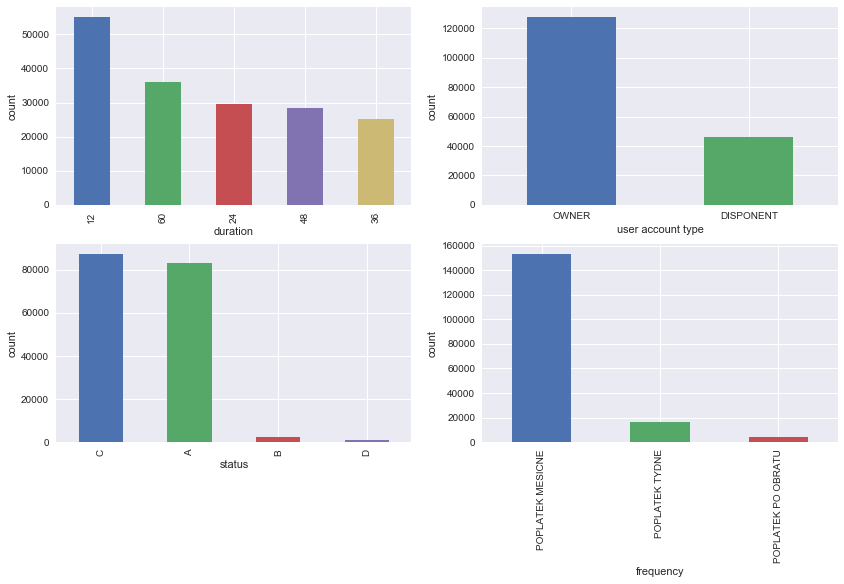

In [ ]:
plt.figure(figsize = (14, 8))
plt.subplot(2, 2, 1)
data_cat.duration.value_counts().plot.bar()
plt.xlabel('duration')
plt.ylabel('count')

plt.subplot(2, 2, 2)
data_cat.type.value_counts().plot.bar()
plt.xlabel('user account type')
plt.ylabel('count')
plt.xticks(rotation = 0)

plt.subplot(2, 2, 3)
data_cat.status.value_counts().plot.bar()
plt.xlabel('status')
plt.ylabel('count')

plt.subplot(2, 2, 4)
data_cat.frequency.value_counts().plot.bar()
plt.xlabel('frequency')
plt.ylabel('count')

plt.show()

In [ ]:
# check classes in categorical columns
def check_value_counts(x):
    return len(x.value_counts())

In [ ]:
pd.DataFrame(data_cat.apply(lambda x: check_value_counts(x))).T

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,170,170,5,4,354,13,351,47127,60,60,8,170,160,3,162,206,206,2,205


In [ ]:
data_cat_dum = pd.get_dummies(data_cat[['duration', 'status', 'bank_to', 'region','frequency','type']])

In [ ]:
data_num.var() # to check variance

payments                                            5.170595e+06
amount                                              1.667617e+08
balance                                             5.923564e+08
no. of inhabitants                                  1.087212e+11
no. of municipalities with inhabitants < 499        9.304852e+02
no. of municipalities with inhabitants 500-1999     2.616588e+02
no. of municipalities with inhabitants 2000-9999    1.771684e+01
no. of municipalities with inhabitants >10000       1.316124e+00
no. of cities                                       8.735643e+00
ratio of urban inhabitants                          4.137929e+02
average salary                                      1.593380e+06
unemploymant rate 95                                3.592341e+00
unemploymant rate 96                                4.768352e+00
no. of enterpreneurs per 1000 inhabitants           4.749725e+02
no. of commited crimes 95                           6.111504e+08
no. of commited crimes 96

In [ ]:
# let's remove variance from columns
scaler = StandardScaler()

In [ ]:
data_num_sca = scaler.fit_transform(data_num)

C:\Users\nick2\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nick2\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
data_num_sca = pd.DataFrame(data_num_sca, index = data_num.index, columns = data_num.columns)

In [ ]:
data_new = pd.concat([data_cat_dum, data_num_sca], axis = 1) # combining numerical and object dataframes back

In [ ]:
data_new.shape

(174249, 51)

In [ ]:
pd.DataFrame((np.random.random(len(data)) < .05).astype(int))[0].value_counts()

0    165482
1      8767
Name: 0, dtype: int64